In [1]:
""" Imports """
import os
import random
import re
from math import pi, sin, cos
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from scipy.ndimage import binary_erosion
from skimage.io import imread
from scipy.ndimage import center_of_mass
from skimage.filters import threshold_local
from skimage.morphology import remove_small_objects
%matplotlib inline
plt.style.use('seaborn-v0_8')

Let's add instantiate some globals

In [5]:
data_dir = "C:/Users/Olle de Jong/Documents/MSc Biology/MSB Research/SignalAnalysisData/Sfp1_GFP/input/"
output_dir = "C:/Users/Olle de Jong/Documents/MSc Biology/MSB Research/SignalAnalysisData/Sfp1_GFP/output/"
tif_dir = data_dir + "Processed_Tiffs/"

scaling_factor = 0.16  # microns per pixel ---> 100x objective

Some functions we will need along the way

In [6]:
# some needed functions
def ellipse_from_budj(t, cell_data):
    """
    Define the function that can extract parameters of the ellipse using the data
    Function to extract parameters of the ellipse from the BudJ table
    """
    data_at_frame = cell_data[cell_data["TimeID"] == t]
    x_pos = float(data_at_frame['x'].iloc[0]) / scaling_factor
    y_pos = float(data_at_frame['y'].iloc[0]) / scaling_factor
    majorR = float(data_at_frame["Major R"].iloc[0]) / scaling_factor
    minorR = float(data_at_frame["Minor r"].iloc[0]) / scaling_factor
    angle = float(data_at_frame['Angle'].iloc[0]) * (pi / 180)  # convert to radians
    return x_pos, y_pos, majorR, minorR, angle

def get_ellipse(imageRFP, nuc_mask):
    """
    Function that generates and fits the ellipse using the opencv package. It takes a nuclear mask as argument.
    """
    mask = imageRFP * nuc_mask
    thresh = mask.astype(np.uint8)  # change type to uint8

    contours, hierarchy = cv.findContours(thresh, 1, 2)

    # if there is a contour found
    if len(contours) > 0:
        cnt = max(contours,key=len)
        if len(cnt) > 4:
            return cv.fitEllipse(cnt)

def round_up_to_odd(f):
    """
    Rounds up any number to a whole odd integer
    """
    return int(np.ceil(f) // 2 * 2 + 1)

def get_whole_cell_mask(t, single_cell_data, image_shape):
    # get/calculate the ellipse information
    x_pos, y_pos, majorR, minorR, A = ellipse_from_budj(t, single_cell_data)
    # print(f"The scaled whole cell radii are: {minorR} and {majorR}")

    y_dim, x_dim = image_shape  # get the dimensions (512x512)

    # create an ogrid that helps us select/'mask' the info we want
    row, col = np.ogrid[:y_dim, :x_dim]

    # get the mask of the whole cell
    return (
            (
                (((col - x_pos) * cos(A) + (row - y_pos) * sin(A)) ** 2) / (majorR ** 2)
                 +
                (((col - x_pos) * sin(A) - (row - y_pos) * cos(A)) ** 2) / (minorR ** 2) - 1
            ) # if this sum
            < 0  # is smaller than zero
    ), x_pos, y_pos

def save_figure(path, bbox_inches='tight', dpi=300):
    """
    Custom function that lets you save a pyplot figure and creates the directory where necessary
    """
    directory = os.path.split(path)[0]
    filename = os.path.split(path)[1]
    if directory == '':
        directory = '.'

    if not os.path.exists(directory):
        os.makedirs(directory)

    savepath = os.path.join(directory, filename)

    # Actually save the figure
    plt.savefig(savepath, bbox_inches=bbox_inches, dpi=dpi)
    plt.close()

def plot_from_list(fig_title, data_list, xlim, ylim, color):
    """
    Given a dictionary that holds image plot titles and data, plot those in one figure.
    """
    plt.figure(figsize=(3.6 * len(data_list), 4.1), edgecolor="black", frameon=True, facecolor="white",
               layout="tight").suptitle(fig_title, fontsize=14, y=1)
    i = 1
    for data in data_list:
        subplt = plt.subplot(1, len(data_list), i)
        subplt.set_title(label=data[0], y=1.02)
        plt.imshow(data[1], cmap=color)
        subplt.grid(False)
        plt.xlim(xlim)
        plt.ylim(ylim)
        i += 1
    plt.show()

Let's load all the tif images

In [7]:
# load all images
images = {}
for pos in range(1, 11):
    if pos < 10:
        pos = "0" + str(pos)
    pos = str(pos)
    images[pos] = imread(f"{tif_dir}20201002_sfp1_2_pka2d_xy{pos}.nd2.tif")  # load the image

Now we will load all BudJ data into one dataframe

In [8]:
# load all budj data
files = []
for filename in os.listdir(data_dir):
    if "Cell data .csv" in filename:
        cell_name = f"pos{re.findall('(?<=xy)[0-9]{2}', filename)[0]}_"
        files.append((filename, cell_name))

# add the data of all files to one single dataframe
budj_data = pd.DataFrame({})
for filename, cell_name_prefix in files:
    # mother with daughter(s) data
    pos_data = pd.read_csv(data_dir + filename, header=0, index_col=0)
    pos_data["Cell_pos"] = cell_name_prefix + pos_data["Cell"].map(str)
    temp_data = pd.DataFrame(columns=pos_data.columns)
    # name the cells correctly, the mother's name is unchanged, but the daughters are now recognizable
    for index, row in pos_data.iterrows():
        temp_data.loc[len(temp_data) + 1] = row.values

    # keep only the following columns
    temp_data = temp_data.loc[:, ["TimeID", "Cell_pos", "Volume", "x", "y", "Major R", "Minor r", "Angle"]]

    # save the mother + daughter data to the bigger dataframe holding data for all mothers + daughters
    budj_data = pd.concat([budj_data, temp_data])

# sort on cell pos and time-frame
budj_data = budj_data.sort_values(["Cell_pos", "TimeID"]).reset_index(drop=True)
individual_cells = sorted(list(set(budj_data["Cell_pos"])))
print(f"There are {len(individual_cells)} cells in the final dataframe.")

There are 24 cells in the final dataframe.


In [9]:
events_files = {"budding": f"{data_dir}buddings.txt", "kariokinesis": f"{data_dir}kariokinesis.txt"}

budding_events = {}
kario_events = {}
for event_type in events_files:  # for either budding or kariokinesis events
    opened_file = open(events_files[event_type])  # open the file
    events = {}  # temp storage object
    for line in opened_file:  # every line in the file is a cell
        if line == "\n":
            continue
        # process the two parts of the line by removing characters
        parts = line.split(':')
        cell_id = parts[0].replace("\"", "").strip()  # first part of the line is the individual cell
        timepoints_string = re.sub('[\[\]]', "", parts[1])  # second part are the timepoints
        # split timepoints on space to capture them in a list
        timepoints_list = re.findall("([0-9]+)", timepoints_string)
        if len(timepoints_list) < 1:
            continue
        events[cell_id] = timepoints_list # remove redundant last comma

    # save the events to the right dictionary
    if event_type == "budding":
        budding_events = events
    if event_type == "kariokinesis":
        kario_events = events
    opened_file.close()

print(f"There are budding events for {len(budding_events)} cells")
print(f"There are karyokinesis events for {len(kario_events)} cells")

There are budding events for 40 cells
There are karyokinesis events for 40 cells


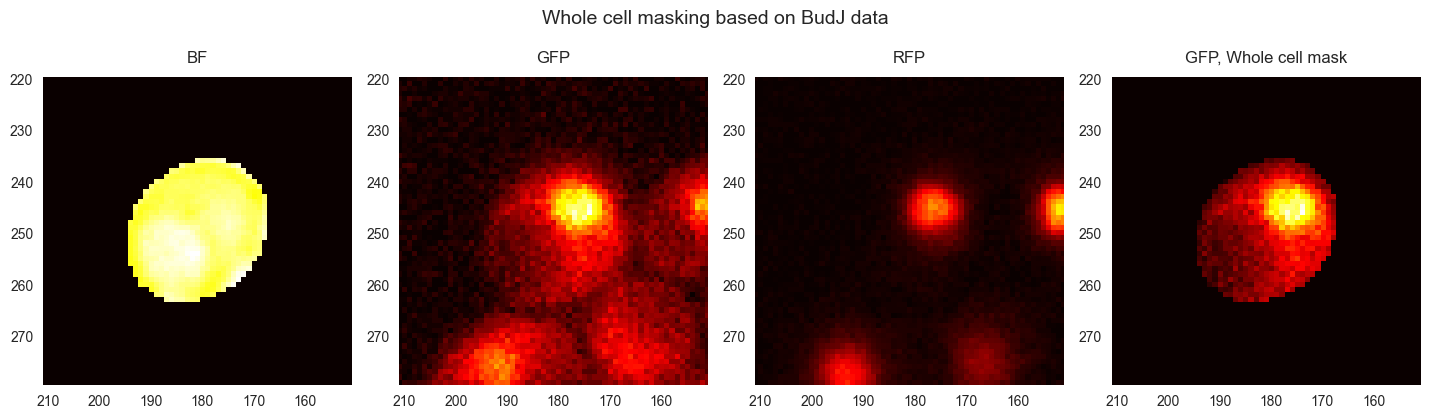

In [10]:
# let's take a look at the whole cell mask
t = 68
t_in_tiff = t - 1  # skew the time by one

# select one image and get the different channels
image = images['01']
imageBF = image[t_in_tiff, :, :, 0]
imageGFP = image[t_in_tiff, :, :, 1]
imageRFP = image[t_in_tiff, :, :, 2]

# one cell data
ss_data = budj_data[budj_data["Cell_pos"] == "pos01_2"]

# get the whole cell mask
whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, ss_data, imageRFP.shape)

# plot the regular BF and RFP channels and compare this to the masked whole cell (based on ImageJ data)
to_plot = [
    ["BF", imageBF * whole_cell_mask],
    ["GFP", imageGFP],
    ["RFP", imageRFP],
    ["GFP, Whole cell mask",  imageGFP * whole_cell_mask]
]

# plot in one figure
plot_from_list(
    fig_title=f"Whole cell masking based on BudJ data",
    data_list=to_plot,
    xlim=(x_pos + 30, x_pos - 30),
    ylim=(y_pos + 30, y_pos - 30),
    color="hot"
)

Different local thresholding settings

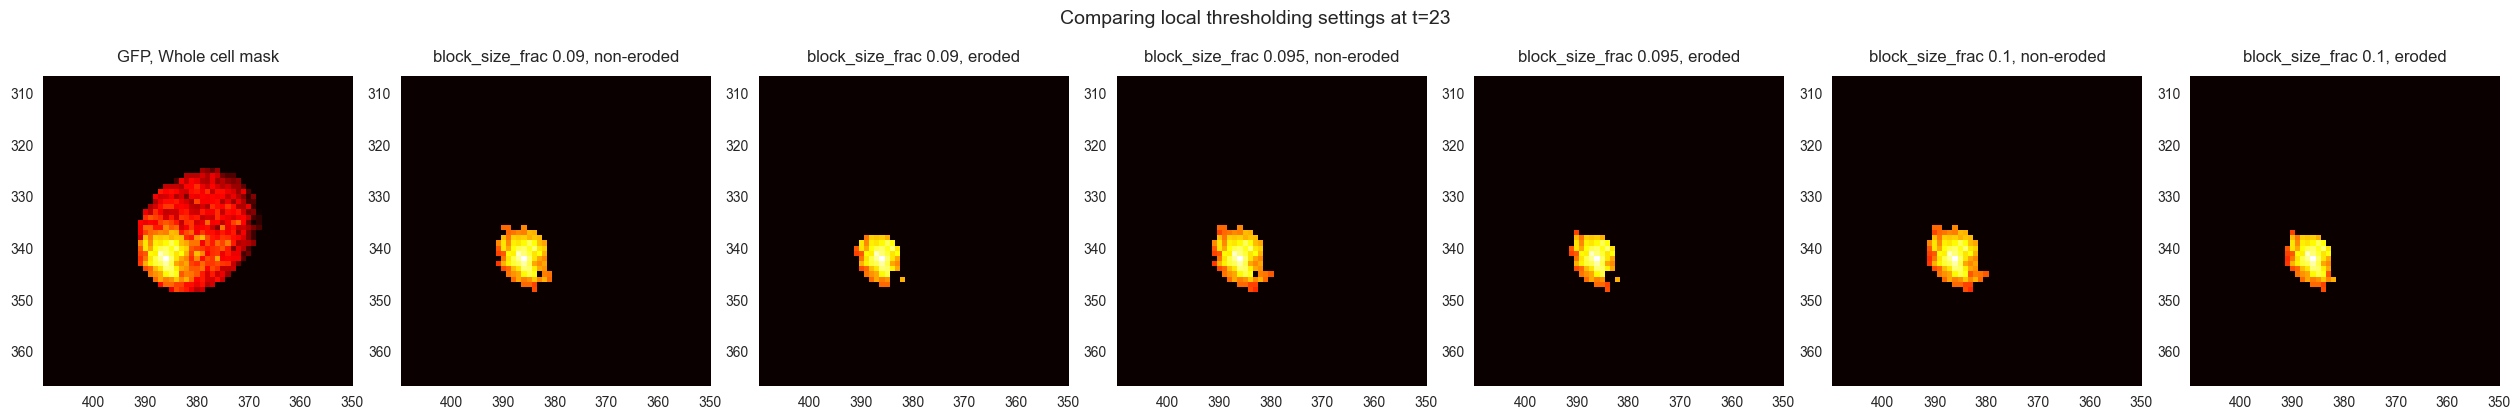

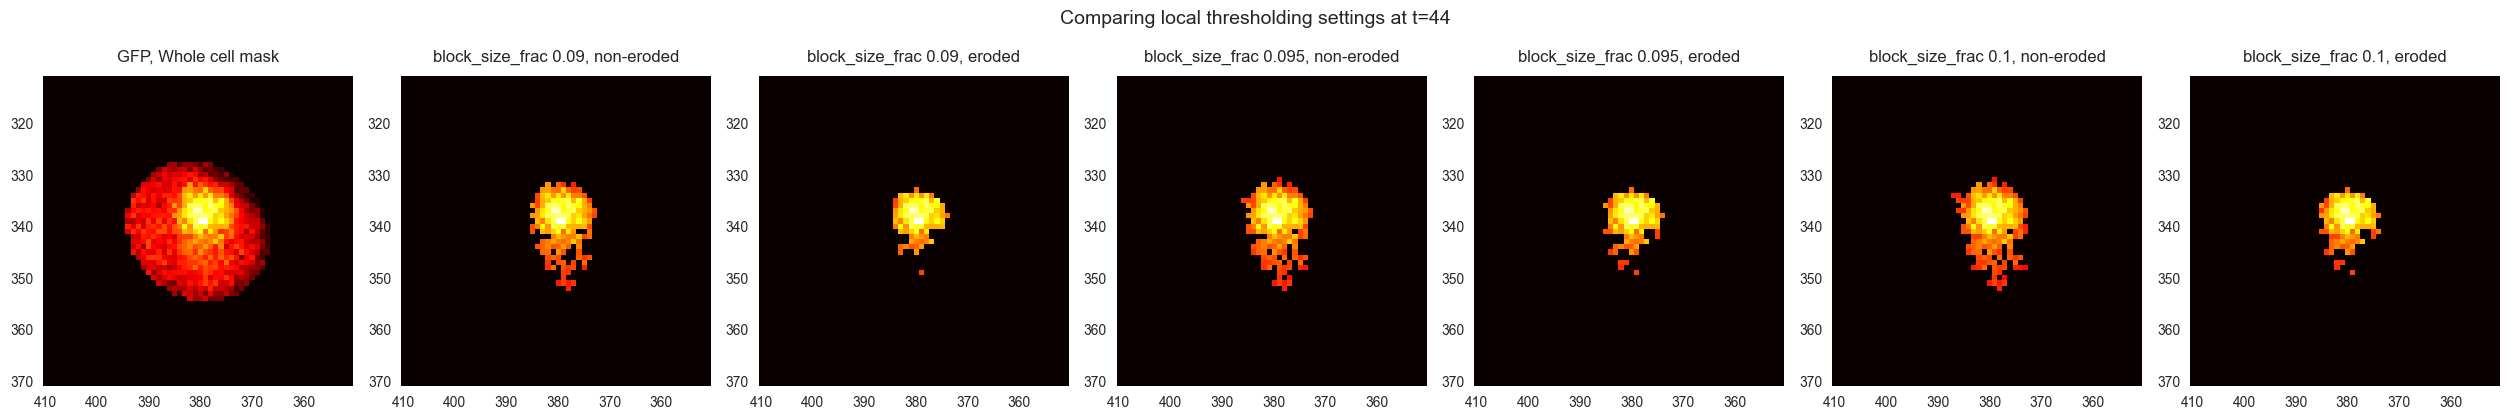

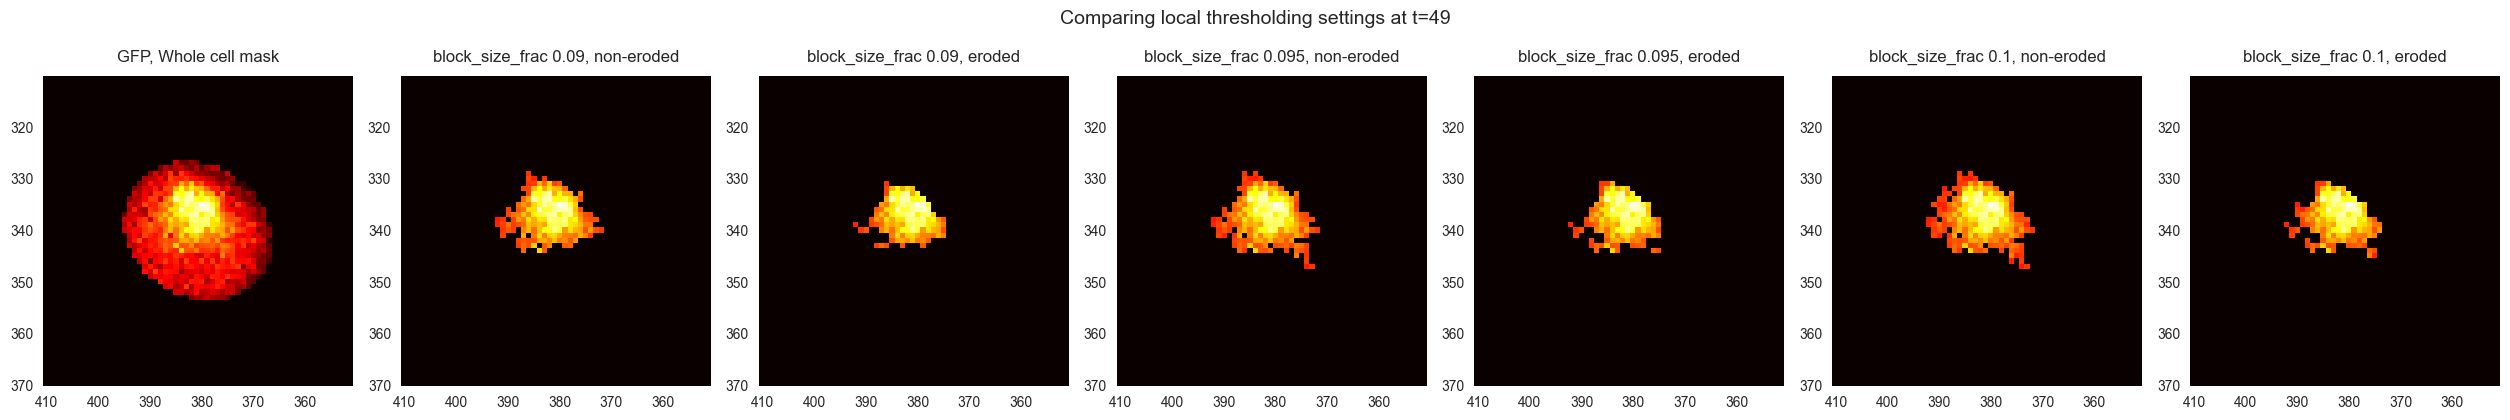

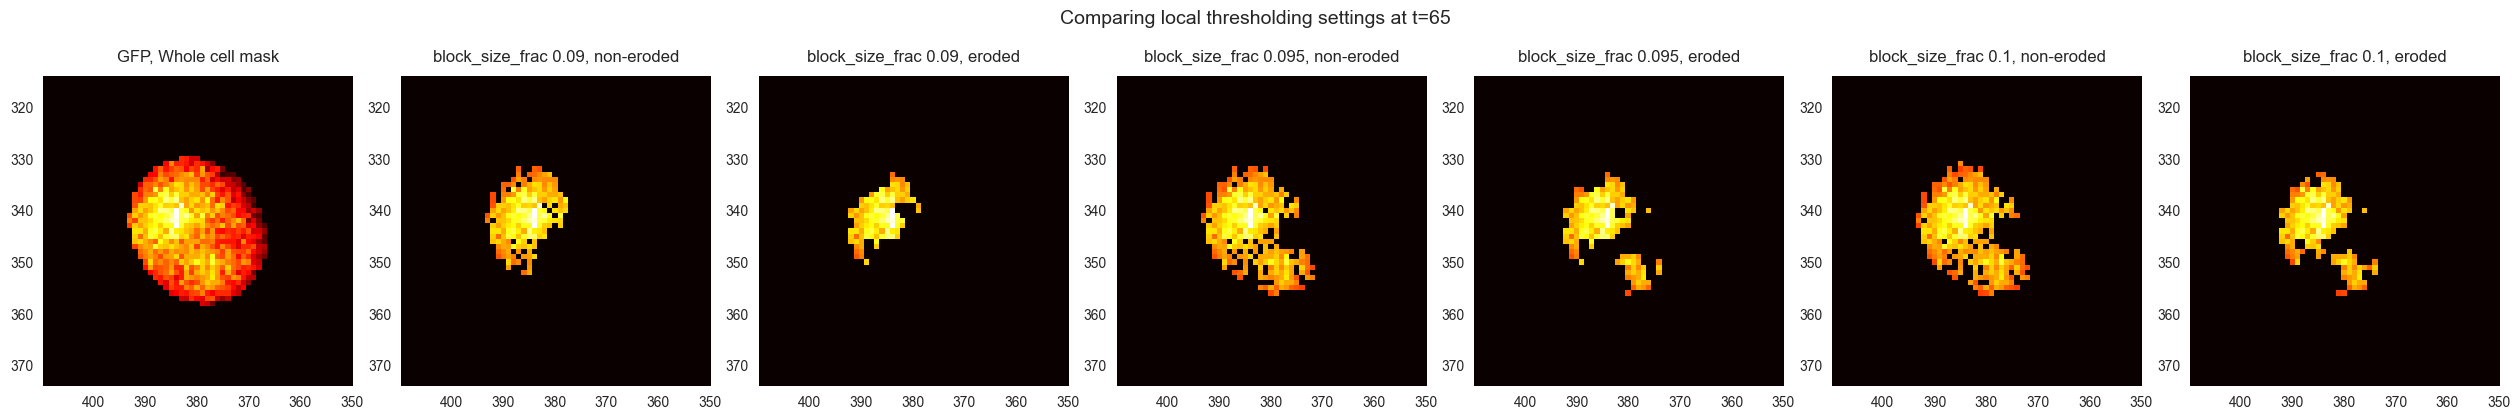

In [11]:
# thresholding parameters
bloc_size_frac_to_use = 0.085
offset_to_use = -15

image = images['09']
image = cv.convertScaleAbs(image, alpha=1.2, beta=0)
ss_data = budj_data[budj_data["Cell_pos"] == "pos09_2"]

# get the first available frame
t_first = ss_data['TimeID'].iloc[0]
t_last = ss_data['TimeID'].iloc[-1]

ts = random.sample(range(t_first, t_last), 4)
for t in ts:
    t_in_tiff = t - 1

    imageBF = image[t_in_tiff, :, :, 0]
    imageGFP = image[t_in_tiff, :, :, 1]
    imageRFP = image[t_in_tiff, :, :, 2]

    whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, ss_data, imageGFP.shape)

                        # PERFORM DIFFERENT THRESHOLD METHODS
    num_cell_pixels = np.count_nonzero(whole_cell_mask == True)

    blksize_1 = 0.09
    blksize_2 = 0.095
    blksize_3 = 0.10
    bloc_size_cell_size_dependent = round_up_to_odd(blksize_1 * num_cell_pixels)
    bloc_size_cell_size_dependent2 = round_up_to_odd(blksize_2 * num_cell_pixels)
    bloc_size_cell_size_dependent3 = round_up_to_odd(blksize_3 * num_cell_pixels)

    # thresholding will be performed not on all image but on a fraction of it which includes the cell
    imageGFP_cell_mask = imageGFP * whole_cell_mask

    # thresholding to get the nuclear mask
    nucl_thresh_mask_local = threshold_local(image=imageGFP_cell_mask, block_size=bloc_size_cell_size_dependent, offset=offset_to_use)
    nucl_thresh_mask_local2 = threshold_local(image=imageGFP_cell_mask, block_size=bloc_size_cell_size_dependent2, offset=offset_to_use)
    nucl_thresh_mask_local3 = threshold_local(image=imageGFP_cell_mask, block_size=bloc_size_cell_size_dependent3, offset=offset_to_use)

    # keep the pixels that are greater than the threshold
    imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local)
    imageGFP_nuc_mask_local2 = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local2)
    imageGFP_nuc_mask_local3 = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local3)

    # apply erosion
    imageGFP_nuc_mask_local_eroded = binary_erosion(imageGFP_nuc_mask_local, structure = np.ones((2,2)))
    imageGFP_nuc_mask_local_eroded2 = binary_erosion(imageGFP_nuc_mask_local2, structure = np.ones((2,2)))
    imageGFP_nuc_mask_local_eroded3 = binary_erosion(imageGFP_nuc_mask_local3, structure = np.ones((2,2)))

    to_plot = [
        ["GFP, Whole cell mask",  imageGFP * whole_cell_mask],
        [f"block_size_frac {blksize_1}, non-eroded", imageGFP * imageGFP_nuc_mask_local],
        [f"block_size_frac {blksize_1}, eroded", imageGFP * imageGFP_nuc_mask_local_eroded],
        [f"block_size_frac {blksize_2}, non-eroded", imageGFP * imageGFP_nuc_mask_local2],
        [f"block_size_frac {blksize_2}, eroded", imageGFP * imageGFP_nuc_mask_local_eroded2],
        [f"block_size_frac {blksize_3}, non-eroded", imageGFP * imageGFP_nuc_mask_local3],
        [f"block_size_frac {blksize_3}, eroded", imageGFP * imageGFP_nuc_mask_local_eroded3]
    ]

    plot_from_list(f"Comparing local thresholding settings at t={t}", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30), color="hot")

Demonstration of ellipse fitting on nuclear segmentation.

In [14]:
# TODO Only for the last processed cell above
# get the nuclear ellipse
(x, y), (MA, ma), angle = get_ellipse(imageGFP, imageGFP_nuc_mask_local)
cv2_ellipse_regular = ((x, y), (MA, ma), angle)
(x, y), (MA, ma), angle = get_ellipse(imageGFP, imageGFP_nuc_mask_local_eroded)
cv2_ellipse_lt = ((x, y), (MA, ma), angle)

(c_x, c_y), (c_MA, c_ma), c_angle = get_ellipse(imageGFP, whole_cell_mask)
cv2_ellipse_cell = ((c_x, c_y), (c_MA, c_ma), c_angle)

# plot side by side
to_plot = [
    ["GFP, Fitted cell ellipse", cv.ellipse(imageGFP, cv2_ellipse_cell, (0, 0, 0), 1)],
    ["GFP, Local thresholding", imageGFP * imageGFP_nuc_mask_local2],
    ["GFP, Fitted nuclear ellipse", cv.ellipse(imageGFP * whole_cell_mask, cv2_ellipse_regular, (0, 0, 0), 1)],
    ["GFP, Local thresholding, eroded", imageGFP * imageGFP_nuc_mask_local_eroded2],
    ["GFP, Fitted nuclear ellipse", cv.ellipse(imageGFP * whole_cell_mask, cv2_ellipse_lt, (0, 0, 0), 1)]
]
plot_from_list(f"Ellipse fitting using the Local threshold nuclear mask", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30), color="hot")

print(f"The major and minor axes of the ellipse are {ma} and {MA}, respectively.")

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'ellipse'
> Overload resolution failed:
>  - ellipse() missing required argument 'startAngle' (pos 5)
>  - ellipse() missing required argument 'startAngle' (pos 5)
>  - Layout of the output array img is incompatible with cv::Mat
>  - Expected Ptr<cv::UMat> for argument 'img'


Let's produce an overview of the ellipse fitting over the lifespan of one single cell

In [16]:
bloc_size_frac_to_use = 0.09
offset_to_use = -15

for pos in range(1,11):
    pos = "0"+ str(pos)
    image = images[pos]
    imageGFP = image[:, :, :, 1]

    for cell in individual_cells:
        if 'pos'+str(pos) in cell:
            nothing_found = 0
            thresholded_frames = []
            single_cell_data = budj_data[budj_data["Cell_pos"] == cell]  # pick only the data of the first cell

            for t in single_cell_data.TimeID:
                # skew the time by one for tiff dataframe
                t_in_tiff = t - 1
                imageGFP_at_frame = imageGFP[t_in_tiff, :, :] # get the GFP data

                whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, single_cell_data, imageGFP_at_frame.shape)  # get the cell mask
                imageGFP_cell_mask = imageGFP_at_frame * whole_cell_mask  # keep the part of the GFP channel that is within the cell mask
                num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
                bloc_size_cell_size_dependent = round_up_to_odd(bloc_size_frac_to_use * num_cell_pixels)
                nuc_thresh_mask_local = threshold_local(image=imageGFP_cell_mask, block_size=bloc_size_cell_size_dependent, offset=offset_to_use)
                imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nuc_thresh_mask_local)

                a, b = np.nan_to_num(center_of_mass(imageGFP_nuc_mask_local))

                # if there's no thresholded pixels, then show the masked whole cell (makes it easy to recognize where it went 'well' and where it did not)
                if np.count_nonzero(imageGFP_nuc_mask_local) == 0:
                    nothing_found += 1
                thresholded_frames.append((t, x_pos, y_pos, imageGFP_at_frame * whole_cell_mask, a, b))

            print(f"{cell} - No threshold result {round(nothing_found / len(single_cell_data['TimeID']) * 100)} % of the time")

            plt.ioff()
            fig = plt.figure(figsize=(35, 25), edgecolor="black", frameon=True, facecolor="white", layout="tight").suptitle(f"Cell {cell} - Fitted centroid over time", fontsize=14, y=0.99)
            subplot_num = 1
            for thresh_frame in thresholded_frames:
                t = thresh_frame[0]
                subplt = plt.subplot(10, 15, subplot_num)
                subplt.set_title(label=f"t = {t}", y=1.02)
                plt.imshow(thresh_frame[3], cmap="hot")
                plt.scatter(x=[thresh_frame[5]], y=[thresh_frame[4]], c='b', s=20)
                subplt.grid(False)
                plt.xlim(thresh_frame[1] + 30, thresh_frame[1] - 30)
                plt.ylim(thresh_frame[2] + 30, thresh_frame[2] - 30)
                subplot_num += 1
            save_figure(f"{output_dir}ellipse_overviews/{bloc_size_frac_to_use} and {offset_to_use}/{cell}_centroid_over_time_threshold_local.png")

pos01_1 - No threshold result 0 % of the time


C:\Users\Olle de Jong\Documents\Github\SFP1-Analysis\venv\lib\site-packages\scipy\ndimage\_measurements.py:1407: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


pos01_2 - No threshold result 6 % of the time
pos02_1 - No threshold result 1 % of the time


KeyboardInterrupt: 

After generating ellipse overview images for the following settings:

- bloc_size_frac_to_use: 0.085, offset: -15
- bloc_size_frac_to_use: 0.085, offset: -20
- bloc_size_frac_to_use: 0.09, offset: -15
- bloc_size_frac_to_use: 0.09, offset: -20

The most optimal one is a combination of a bloc_size_frac_to_use of 0.09 and an offset of -15.

Now, let's see if contrast adjustments improve the percentage of recognized nuclei.

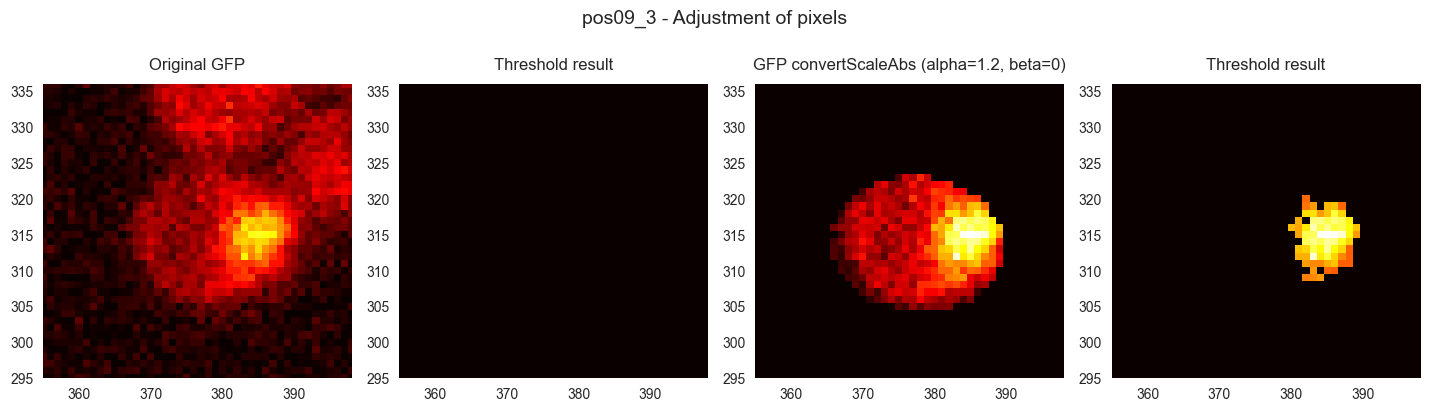

In [26]:
bloc_size_frac_to_use = 0.09
offset_to_use = -15

t = 24
cell_pos = "pos09_3"
image = images['09']
imageGFP = image[t - 1, :, :, 1]
ss_data = budj_data[budj_data["Cell_pos"] == "pos09_3"]

new_image = cv.convertScaleAbs(image, alpha=1.2, beta=0)
new_image_GFP = new_image[t - 1, :, :, 1]

whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, ss_data, imageGFP.shape)  # get the cell mask
num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
bloc_size_cell_size_dependent = round_up_to_odd(bloc_size_frac_to_use * num_cell_pixels)

# original
imageGFP_cell_mask = imageGFP * whole_cell_mask  # keep the part of the GFP channel that is within the cell mask
nuc_thresh_mask_local = threshold_local(image=imageGFP_cell_mask, block_size=bloc_size_cell_size_dependent, offset=offset_to_use)
imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nuc_thresh_mask_local)

# adj
imageADJ_cell_mask = new_image_GFP * whole_cell_mask
nuc_thresh_mask_local_adj = threshold_local(image=imageADJ_cell_mask, block_size=bloc_size_cell_size_dependent, offset=offset_to_use)
imageGFP_nuc_mask_local_adj = remove_small_objects(imageADJ_cell_mask > nuc_thresh_mask_local_adj)

to_plot = [
    ["Original GFP", imageGFP],
    ["Threshold result", imageGFP * imageGFP_nuc_mask_local],
    ["GFP convertScaleAbs (alpha=1.2, beta=0)", new_image_GFP * whole_cell_mask],
    ["Threshold result", new_image_GFP * imageGFP_nuc_mask_local_adj]
]
plot_from_list(f"{cell_pos} - Adjustment of pixels", to_plot, (355, 398), (295, 336), color="hot")